# Using ResNet50 CNN Model

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
training_data = "/content/drive/MyDrive/Data/train"
validation_data = "/content/drive/MyDrive/Data/valid"
testing_data = "/content/drive/MyDrive/Data/test"

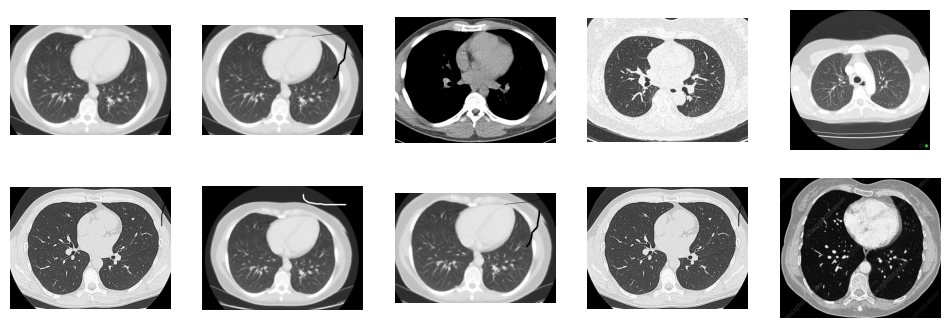

In [4]:
#chest CT-scans Visualize

import os
import random
import matplotlib.pyplot as plt
from matplotlib.image import imread

def display_images(folder):
    image_files = os.listdir(folder)
    fig, ax = plt.subplots(2, 5, figsize=(12, 4))
    for i in range(2):
        for j in range(5):
            image_path = os.path.join(folder, random.choice(image_files))
            image = imread(image_path)
            ax[i, j].imshow(image, cmap='gray')
            ax[i, j].axis('off')
    plt.show()
folder = '/content/drive/MyDrive/Data/train/normal'
display(folder)

In [5]:
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.applications import ResNet50, VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Flatten,Dropout,BatchNormalization
from keras.models import Model
from keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import plot_model 
from IPython.display import Image

In [6]:
image_shape_pixels = (460,460,3)
classes = 4
training_datagen = ImageDataGenerator(
    dtype='float32',
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False
)
validation_datagen = ImageDataGenerator(
    dtype='float32',
    preprocessing_function=preprocess_input
)
testing_datagen = ImageDataGenerator(
    dtype='float32',
    preprocessing_function=preprocess_input
)

training_generator = training_datagen.flow_from_directory(
    training_data,
    target_size=(460,460),
    batch_size=32,
    class_mode='categorical',
    
)


test_generator = testing_datagen.flow_from_directory(
    testing_data,
    target_size=(460,460),
    batch_size=32,
    class_mode='categorical',
)
validation_generator = validation_datagen.flow_from_directory(
    validation_data,
    target_size=(460,460),
    batch_size=32,
    class_mode='categorical',
)

Found 613 images belonging to 4 classes.
Found 315 images belonging to 4 classes.
Found 72 images belonging to 4 classes.


In [17]:
base_model = ResNet50(include_top=False,pooling='av',weights='imagenet',input_shape=(image_shape_pixels))
for layer in base_model.layers:
    layer.trainable = False
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(classes,activation='softmax'))
model.summary()

94765736/94765736 [==============================] - 0s 0us/step
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 15, 15, 2048)      23587712  
                                                                 
 flatten_2 (Flatten)         (None, 460800)            0         
                                                                 
 batch_normalization_2 (Batc  (None, 460800)           1843200   
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 256)               117965056 
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 4)                 

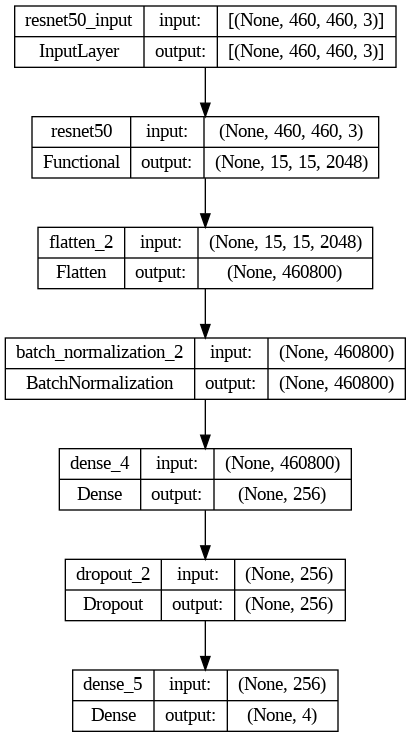

In [18]:
plot_model(model,to_file="resnet50.png",show_shapes=True,show_layer_names=True)
Image(filename="resnet50.png")

In [19]:
optimizer = tf.keras.optimizers.Adam(learning_rate= 0.00001)

model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
checkpoint = ModelCheckpoint(
    filepath='Chest_CT_SCAN_ResNet50.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)
earlystop = EarlyStopping(
    patience=10,
    verbose=1
)
history = model.fit(
    training_generator,
    validation_data=validation_generator,
    epochs=100,
    callbacks=[checkpoint, earlystop],
    verbose=1
)

Epoch 1/100
20/20 [==============================] - ETA: 0s - loss: 1.6988 - accuracy: 0.4535
Epoch 1: val_loss improved from inf to 2.48208, saving model to Chest_CT_SCAN_ResNet50.h5
20/20 [==============================] - 55s 2s/step - loss: 1.6988 - accuracy: 0.4535 - val_loss: 2.4821 - val_accuracy: 0.4722
Epoch 2/100
20/20 [==============================] - ETA: 0s - loss: 1.1923 - accuracy: 0.5922
Epoch 2: val_loss improved from 2.48208 to 1.55312, saving model to Chest_CT_SCAN_ResNet50.h5
20/20 [==============================] - 45s 2s/step - loss: 1.1923 - accuracy: 0.5922 - val_loss: 1.5531 - val_accuracy: 0.5556
Epoch 3/100
20/20 [==============================] - ETA: 0s - loss: 1.0324 - accuracy: 0.6444
Epoch 3: val_loss improved from 1.55312 to 1.48682, saving model to Chest_CT_SCAN_ResNet50.h5
20/20 [==============================] - 51s 3s/step - loss: 1.0324 - accuracy: 0.6444 - val_loss: 1.4868 - val_accuracy: 0.5833
Epoch 4/100
20/20 [==============================]

In [20]:
result = model.evaluate(test_generator)

10/10 [==============================] - 27s 3s/step - loss: 0.4789 - accuracy: 0.8603


In [21]:
model.save('/content/drive/MyDrive/Data/ResNet50.h5')


In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image

# Load the trained model
model = tf.keras.models.load_model('/content/drive/MyDrive/Data/ResNet50.h5')

# Preprocess the input image
input_image_path = '/content/drive/MyDrive/Data/test/normal/10 (2).png'
input_image = image.load_img(input_image_path, target_size=(460, 460))
input_image = image.img_to_array(input_image)
input_image = np.expand_dims(input_image, axis=0)
input_image = preprocess_input(input_image)

# Make predictions
predictions = model.predict(input_image)
predicted_class = np.argmax(predictions, axis=-1)

# Print the predicted class
print(predictions)
print('Predicted class:', predicted_class)


1/1 [==============================] - 9s 9s/step
[[6.8892867e-08 2.8866381e-08 9.9999988e-01 3.0512231e-09]]
Predicted class: [2]


# Using VGG16 CNN Model

In [8]:
vgg_model= VGG16(include_top = False,pooling='avg',weights='imagenet',input_shape=(image_shape_pixels))

for layer in vgg_model.layers: 
    layer.trainable = False

model = Sequential()
model.add(vgg_model)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(4096,activation='relu'))
model.add(Dense(1072,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(classes,activation='softmax'))
model.summary()

58889256/58889256 [==============================] - 4s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 4096)              2101248   
                                                                 
 dense_1 (Dense)             (None, 1072)              4391984   
                                                                 
 dropout (Dropout)           (None, 1072)              0 

In [9]:
optimizer = tf.keras.optimizers.Adam(learning_rate= 0.00001)

model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
checkpoint = ModelCheckpoint(
    filepath='Vgg16_Model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)
earlystop = EarlyStopping(
    patience=10,
    verbose=1
)
history = model.fit(
    training_generator,
    validation_data=validation_generator,
    epochs=100,
    callbacks=[checkpoint, earlystop],
    verbose=1
)

Epoch 1/100
20/20 [==============================] - ETA: 0s - loss: 1.3701 - accuracy: 0.3393 
Epoch 1: val_loss improved from inf to 1.36784, saving model to Vgg16_Model.h5
20/20 [==============================] - 392s 19s/step - loss: 1.3701 - accuracy: 0.3393 - val_loss: 1.3678 - val_accuracy: 0.2500
Epoch 2/100
20/20 [==============================] - ETA: 0s - loss: 1.1081 - accuracy: 0.5318
Epoch 2: val_loss improved from 1.36784 to 1.24844, saving model to Vgg16_Model.h5
20/20 [==============================] - 38s 2s/step - loss: 1.1081 - accuracy: 0.5318 - val_loss: 1.2484 - val_accuracy: 0.4861
Epoch 3/100
20/20 [==============================] - ETA: 0s - loss: 0.9853 - accuracy: 0.5889
Epoch 3: val_loss improved from 1.24844 to 1.11333, saving model to Vgg16_Model.h5
20/20 [==============================] - 38s 2s/step - loss: 0.9853 - accuracy: 0.5889 - val_loss: 1.1133 - val_accuracy: 0.5000
Epoch 4/100
20/20 [==============================] - ETA: 0s - loss: 0.9561 - ac

In [10]:
result = model.evaluate(test_generator)

10/10 [==============================] - 204s 23s/step - loss: 0.4571 - accuracy: 0.8317


In [11]:
model.save('/content/drive/MyDrive/Data/VGG16.h5')

In [16]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image

# Load the trained model
model = tf.keras.models.load_model('/content/drive/MyDrive/Data/VGG16.h5')

# Preprocess the input image
input_image_path = '/content/000116 (2).png'
input_image = image.load_img(input_image_path, target_size=(460, 460))
input_image = image.img_to_array(input_image)
input_image = np.expand_dims(input_image, axis=0)
input_image = preprocess_input(input_image)

# Make predictions
predictions = model.predict(input_image)
predicted_class = np.argmax(predictions, axis=-1)

# Print the predicted class
print(predictions)
print('Predicted class:', predicted_class)


1/1 [==============================] - 0s 168ms/step
[[8.83355588e-02 2.15839432e-03 1.06547435e-04 9.09399450e-01]]
Predicted class: [3]


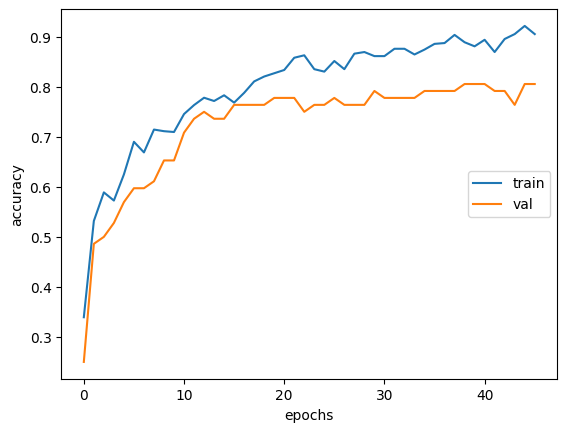

In [17]:
plt.plot(history.history['accuracy'], label = 'train',)
plt.plot(history.history['val_accuracy'], label = 'val')

plt.legend(loc = 'right')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()